# *Importing libraries*

In [2]:
import os
import shutil 
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import save_model, load_model, Model
from tensorflow.keras.layers import Input, InputLayer, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from sklearn.metrics import classification_report
#from keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import imutils
from keras.models import Sequential
import cv2 as cv2

# *Working with data*

Moving images from folders to bigger folder combined

In [3]:
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
data_co = {}
main_path = '/home/noor/Documents/new_test/data/'
for path in os.listdir(main_path):
  for img in os.listdir(f'{main_path}{path}'):
    data_co[img] = path
    shutil.move(f'{main_path}{path}/{img}', main_path)

Removing folders 

In [4]:
!rm -d '/home/noor/Documents/new_test/data/glioma'
!rm -d '/home/noor/Documents/new_test/data/meningioma'
!rm -d '/home/noor/Documents/new_test/data/notumor'
!rm -d '/home/noor/Documents/new_test/data/pituitary'

In [5]:
x = pd.DataFrame(data_co.items(), columns = ['image_id', 'class'])
x['class'].value_counts()

notumor       2000
pituitary     1757
meningioma    1645
glioma        1624
Name: class, dtype: int64

function to crop images

In [6]:
def crop_margins(path):
  img = imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  _,binary = cv2.threshold(gray, 20, 255, cv2.THRESH_BINARY)

  # find contours from thresholded image
  contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  items = cv2.findContours(binary.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  contours = imutils.grab_contours(items)
  c = max(contours, key =cv2.contourArea)
  extLeft = tuple(c[c[:, :, 0].argmin()][0])
  extRight = tuple(c[c[:, :, 0].argmax()][0])
  extTop = tuple(c[c[:, :, 1].argmin()][0])
  extBot = tuple(c[c[:, :, 1].argmax()][0])
  ADD_PIXELS = 0 
  new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS,extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
  
  # image resizing
  IMG_SIZE = 224
  new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
  return new_img


Applying cropping and resizing function on dataset

In [7]:
save_path = '/home/noor/Documents/new_test/dataset'
in_path = os.path.join('/home/noor/Documents/new_test/data/')

if not os.path.isdir(save_path):
  os.makedirs(save_path)

for img in os.listdir(in_path):
  imsave(f'{save_path}/{img}', crop_margins(f'{in_path}/{img}'))

Creating new sub folders 

In [8]:
subfiles = ['/testing/glioma/' , '/testing/meningioma/' , '/testing/notumor/' ,
'/testing/pituitary/','/training/glioma/' , '/training/meningioma/' , '/training/notumor/' , '/training/pituitary/', '/validation/glioma/',
'/validation/meningioma/', '/validation/notumor/', '/validation/pituitary/']

for path in subfiles:
  if not os.path.isdir(f'{save_path}/{path}'):
    os.makedirs(f'{save_path}/{path}')

In [9]:
x.head()

,image_id,class
0,Tr-me_0274.jpg,meningioma
1,Tr-me_0858.jpg,meningioma
2,Tr-me_1037.jpg,meningioma
3,Tr-me_0821.jpg,meningioma
4,Tr-me_0308.jpg,meningioma


Splitting into training , validation and testing

In [10]:
# training and testing set --> setting aside 20% of test , 80% of train 

x_train, x_test, y_train, y_test = train_test_split(x[['image_id']].values, x[['class']].values, test_size = 0.2, random_state = 8)

# using same function above to split the validation set (0.25*0.8=0.2)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.25, random_state=8)

In [11]:
training = x_train.flatten().tolist()
validation = x_val.flatten().tolist()
testing = x_test.flatten().tolist()

x.loc[x['image_id'].isin(training)].to_csv('training.csv', index=False, encoding='utf-8-sig')
x.loc[x['image_id'].isin(validation)].to_csv('validation.csv', index=False, encoding='utf-8-sig')
x.loc[x['image_id'].isin(testing)].to_csv('testing.csv', index=False, encoding='utf-8-sig')


In [12]:
testing = pd.read_csv('./testing.csv')
validation = pd.read_csv('./validation.csv')
training = pd.read_csv('./training.csv')

copying images into their subfolders 

In [13]:
import shutil
main_path = '/home/noor/Documents/new_test/dataset'
for indx, row in training.iterrows():
    shutil.move(f"{main_path}/{row['image_id']}",f"{main_path}/training/{row['class']}/{row['image_id']}")

for indx, row in validation.iterrows():
    shutil.move(f"{main_path}/{row['image_id']}",f"{main_path}/validation/{row['class']}/{row['image_id']}")


for indx,row in testing.iterrows():
    shutil.move(f"{main_path}/{row['image_id']}",f"{main_path}/testing/{row['class']}/{row['image_id']}") 

In [14]:
x_train.shape # 60%

(4215, 1)

In [15]:
x_val.shape # 20%

(1405, 1)

In [16]:
x_test.shape # 20%

(1406, 1)

# CNN Model 

In [17]:
# Model architecture

In [18]:
image_shape = (224, 224, 3)


In [19]:
# Model architecture NUMBER 1 

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(224,224,3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.2))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.2))

model.add(Conv2D(128,kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.2))

model.add(Conv2D(64,kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.2))

model.add(Conv2D(32,kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(4, activation='softmax'))


2022-08-06 17:36:24.692378: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/noor/.local/lib/python3.10/site-packages/cv2/../../lib64:
2022-08-06 17:36:24.692417: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-06 17:36:24.692439: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (noor): /proc/driver/nvidia/version does not exist
2022-08-06 17:36:24.692827: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [33]:
# Model architecture NUMBER 2

model2 = Sequential()

model2.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(224,224,3)))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2,2)))


model2.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2,2)))


model2.add(Conv2D(128,kernel_size=(3,3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(Dropout(rate=0.2))

model2.add(Conv2D(64,kernel_size=(3,3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2,2)))

model2.add(Conv2D(32,kernel_size=(3,3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2,2)))


model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(rate=0.2))
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(rate=0.2))

model2.add(Dense(4, activation='softmax'))

In [51]:
# Model architecture NUMBER 3

model3 = Sequential()

model3.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', input_shape=(224,224,3)))
model3.add(BatchNormalization())
model3.add(MaxPool2D(pool_size=(2,2)))


model3.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPool2D(pool_size=(2,2)))


model3.add(Conv2D(32,kernel_size=(3,3), activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPool2D(pool_size=(2,2)))




model3.add(Flatten())
model3.add(Dense(512, activation='relu'))
model3.add(Dropout(rate=0.2))
model3.add(Dense(512, activation='relu'))
model3.add(Dropout(rate=0.2))

model3.add(Dense(4, activation='softmax'))

In [20]:
train_data = ImageDataGenerator(rescale=1./255,
                                    shear_range=0.2,
                                    rotation_range=2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True)

In [21]:
training_set = train_data.flow_from_directory(directory="/home/noor/Documents/new_test/dataset/training",
                                                  target_size=(224,224),
                                                  class_mode='categorical',
                                                  batch_size=32)

Found 4215 images belonging to 4 classes.


In [22]:
validation_data = ImageDataGenerator(rescale=1./255)

In [23]:
validation_set = validation_data.flow_from_directory(directory="/home/noor/Documents/new_test/dataset/validation",
                                                        target_size=(224,224),
                                                        class_mode='categorical',
                                                        batch_size=1,
                                                        shuffle = False)

Found 1405 images belonging to 4 classes.


In [37]:
test_set = validation_data.flow_from_directory(directory="/home/noor/Documents/new_test/dataset/testing",
                                                        target_size=(224,224),
                                                        class_mode='categorical',
                                                        batch_size=1,
                                                        shuffle = False)

Found 1406 images belonging to 4 classes.


In [24]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

In [34]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)


In [26]:
early = EarlyStopping(monitor = 'val_loss',
                      min_delta = 0,
                      patience = 8,
                      verbose = 1,
                      mode = 'auto')

In [28]:
model_history = model.fit(x=training_set,validation_data=validation_set,epochs=50, callbacks = early,verbose=1)

Epoch 1/50
132/132 [==============================] - 104s 787ms/step - loss: 0.1168 - accuracy: 0.9590 - val_loss: 0.3161 - val_accuracy: 0.9096
Epoch 2/50
132/132 [==============================] - 108s 819ms/step - loss: 0.1111 - accuracy: 0.9585 - val_loss: 0.3540 - val_accuracy: 0.8975
Epoch 3/50
132/132 [==============================] - 114s 860ms/step - loss: 0.1050 - accuracy: 0.9601 - val_loss: 0.1565 - val_accuracy: 0.9559
Epoch 4/50
132/132 [==============================] - 121s 915ms/step - loss: 0.1121 - accuracy: 0.9604 - val_loss: 1.0874 - val_accuracy: 0.7117
Epoch 5/50
132/132 [==============================] - 124s 936ms/step - loss: 0.0904 - accuracy: 0.9684 - val_loss: 0.1745 - val_accuracy: 0.9416
Epoch 6/50
132/132 [==============================] - 125s 949ms/step - loss: 0.1004 - accuracy: 0.9675 - val_loss: 0.1683 - val_accuracy: 0.9452
Epoch 7/50
132/132 [==============================] - 110s 835ms/step - loss: 0.1130 - accuracy: 0.9649 - val_loss: 0.2744 -

In [29]:
model.evaluate(validation_set)

1405/1405 [==============================] - 13s 9ms/step - loss: 1.3912 - accuracy: 0.7929


[1.391221046447754, 0.7928825616836548]

In [ ]:
model.evaluate

In [35]:
model2.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)

In [36]:
model_history = model2.fit(x=training_set,validation_data=validation_set,epochs=50, callbacks = early,verbose=1)

Epoch 1/50
132/132 [==============================] - 110s 828ms/step - loss: 1.1452 - accuracy: 0.5991 - val_loss: 1.3629 - val_accuracy: 0.4669
Epoch 2/50
132/132 [==============================] - 105s 793ms/step - loss: 0.6694 - accuracy: 0.7333 - val_loss: 1.2329 - val_accuracy: 0.5004
Epoch 3/50
132/132 [==============================] - 105s 794ms/step - loss: 0.5536 - accuracy: 0.7862 - val_loss: 0.6694 - val_accuracy: 0.7452
Epoch 4/50
132/132 [==============================] - 106s 800ms/step - loss: 0.4800 - accuracy: 0.8152 - val_loss: 0.6595 - val_accuracy: 0.7416
Epoch 5/50
132/132 [==============================] - 106s 803ms/step - loss: 0.4050 - accuracy: 0.8456 - val_loss: 0.7548 - val_accuracy: 0.7395
Epoch 6/50
132/132 [==============================] - 106s 798ms/step - loss: 0.3612 - accuracy: 0.8679 - val_loss: 0.7103 - val_accuracy: 0.7210
Epoch 7/50
132/132 [==============================] - 106s 804ms/step - loss: 0.3396 - accuracy: 0.8769 - val_loss: 0.6134 -

In [52]:
model3.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)

In [1]:
model_history = model3.fit(x=training_set,validation_data=validation_set,epochs=50,batch_size=64, callbacks = early,verbose=1)

NameError: name 'model3' is not defined

In [38]:
model.evaluate(test_set)

1406/1406 [==============================] - 12s 9ms/step - loss: 1.3735 - accuracy: 0.7873


[1.3735157251358032, 0.787339985370636]

In [39]:
model2.evaluate(test_set)

1406/1406 [==============================] - 12s 9ms/step - loss: 0.1946 - accuracy: 0.9403


[0.194618821144104, 0.9402560591697693]

In [40]:
def plot_confusion_matrix(true_lab,predict_lab,classes,path):
  matrix_confusion = tf.math.confusion_matrix(labels=true_lab, predictions=predicted_lab, num_classes=len(classes))
  ax = plt.subplot()
  sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=True)
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels(classes)
  ax.yaxis.set_ticklabels(classes)
  plt.savefig(f'{path}confusion_matrix.png')

In [41]:
def dump_text(text,path):
  text_file = open(path, "w")
  text_file.write(text)
  text_file.close()

In [44]:
savepath = '/home/noor/Documents/new_test/'

1406/1406 [==============================] - 12s 9ms/step
              precision    recall  f1-score   support

      glioma       0.98      0.84      0.90       294
  meningioma       0.86      0.94      0.90       358
     notumor       0.96      0.99      0.97       397
   pituitary       0.98      0.97      0.98       357

    accuracy                           0.94      1406
   macro avg       0.95      0.93      0.94      1406
weighted avg       0.94      0.94      0.94      1406



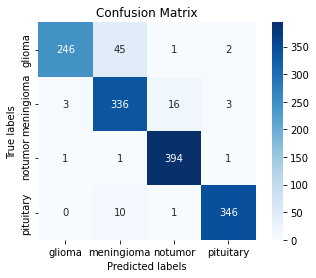

In [47]:
p = model2.predict(test_set)
predicted_lab = p.argmax(axis=-1)
true_lab = test_set.classes
plot_confusion_matrix(true_lab, predicted_lab, test_set.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=test_set.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')